In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dog_epidemic.Utils as utils
from datetime import date
import numpy as np
import shapely
from shapely import Point
from shapely import Polygon
import random
import geopandas as gp
import geoplot as gpplt
import math
import numpy



In [2]:
all_dogs = gp.read_parquet('ALLNYCDogs.parquet')

In [84]:
# set parameters
n_initially_infected = 1
n_generation_intervals = 6
distance = 0.01
buffer = 0.0008
max_exposed_per_dog= 10
i = 0
frame = 0
SEIR_report = pd.DataFrame({'Susceptible': [], 
                            'Exposed': [], 
                            'Infected': [], 
                            'Recovered': []})
R_report = pd.DataFrame()

# Set initial conditions

# Randomly infect the first generation of dogs
exposed_dogs = all_dogs.sample(n_initially_infected)

# Remove infected dogs from susceptible dogs 
susceptible_dogs = pd.merge(all_dogs.set_index('ID'), 
                             exposed_dogs['ID'], 
                             on = ['ID'], how = 'outer',
                             suffixes = ('', '_ex'),
                             indicator=True).query('_merge=="left_only"').drop('_merge', axis = 1)

recovered_dogs = pd.DataFrame()

infected_dogs = pd.DataFrame()

new_row = pd.DataFrame.from_records([{'Susceptible': len(susceptible_dogs), 
           'Exposed': len(exposed_dogs),
           'Infected': len(infected_dogs),
           'Recovered': len(recovered_dogs),
           'Step': 0}])
SEIR_report = pd.concat([SEIR_report, new_row], ignore_index=True)

# Run simulation for n generation intervals
while i < n_generation_intervals: 
    i = i + 1
    # Move dogs to next compartment
    recovered_dogs = pd.concat([recovered_dogs, infected_dogs])
    infected_dogs = exposed_dogs
    exposed_dogs = pd.DataFrame()

    # Show infected dogs at start of step
    fig, ax = plt.subplots(figsize=(15, 15))
    figname = 'Figures/' + str(frame) + '.png'
    infected_dogs['geometry'].plot(ax = ax, color = 'lightgray')
    if len(recovered_dogs) > 0 :
        recovered_dogs['geometry'].plot(ax = ax, color = 'lightgray')
        recovered_dogs['locations'].plot(ax = ax, 
                                    color = 'slateblue',
                                    alpha = 0.5, edgecolor = 'none')
    infected_dogs['locations'].plot(ax = ax, 
                                    color = 'red',
                                    alpha = 0.5, edgecolor = 'none')
    fig.savefig(figname, format= 'png')
    plt.close(fig)
    frame = frame + 1

    # Create walks for infected dogs 
    infected_dogs['walk'] = infected_dogs.apply(utils.create_walk, axis =1, 
                                                location = 'locations', 
                                                distance = distance, 
                                                buffer = buffer)

    # Show area of exposure
    fig, ax = plt.subplots(figsize=(15, 15))
    figname = 'Figures/' + str(frame) + '.png'
    infected_dogs['geometry'].plot(ax = ax, color = 'lightgray')
    if len(recovered_dogs) > 0 :
        recovered_dogs['geometry'].plot(ax = ax, color = 'lightgray')
        recovered_dogs['locations'].plot(ax = ax, 
                                         color = 'slateblue',
                                         alpha = 0.5, 
                                         edgecolor = 'none')
    infected_dogs['walk'].plot(ax = ax, 
                               color = 'pink',
                               alpha = 0.5, 
                               edgecolor = 'none')
    infected_dogs['locations'].plot(ax = ax, 
                                    color = 'red',
                                    alpha = 0.5, 
                                    edgecolor = 'none')
    fig.savefig(figname, format= 'png')
    plt.close(fig)
    frame = frame + 1

    # Find all dogs exposed during this step
    for index, row in infected_dogs.iterrows():
        new_exposures = utils.infect_dog_along_walk(row,
                            walk = 'walk',
                            infected_dogs=infected_dogs, 
                            recovered_dogs=recovered_dogs, 
                            susceptible_dogs=susceptible_dogs,
                            exposed_dogs= exposed_dogs,
                            location='locations', 
                            max_exposed = max_exposed_per_dog)
        exposed_dogs= pd.concat([exposed_dogs,new_exposures])
        for index, exposed in new_exposures.iterrows():
            new_row = pd.DataFrame.from_records([{'InfectorID': row['ID'],
                                                'Infector_ZipCode': row['ZipCode'],
                                                'Infector_geometry': row['geometry'],
                                                'Infector_location': row['locations'],
                                                'ExposedID': exposed['ID'],
                                                'Exposed_ZipCode': exposed['ZipCode'],
                                                'Exposed_geometry': exposed['geometry'],
                                                'Exposed_location': row['locations'],
                                                'Count': 1,
                                                'Step': i}])
            R_report = pd.concat([R_report, new_row], ignore_index = True)


    susceptible_dogs = pd.merge(susceptible_dogs.set_index('ID'), 
                             exposed_dogs['ID'], 
                             on = ['ID'], how = 'outer',
                             suffixes = ('', '_ex'),
                             indicator=True).query('_merge=="left_only"').drop('_merge', axis = 1)
    # Plot newly exposed dogs 
    fig, ax = plt.subplots(figsize=(15, 15))
    figname = 'Figures/' + str(frame) + '.png'
    exposed_dogs['geometry'].plot(ax = ax, color = 'lightgray')
    infected_dogs['geometry'].plot(ax = ax, color = 'lightgray')
    if len(recovered_dogs) > 0 :
        recovered_dogs['geometry'].plot(ax = ax, color = 'lightgray')
        recovered_dogs['locations'].plot(ax = ax, color = 'slateblue',
                                         alpha = 0.5, edgecolor = 'none')
    infected_dogs['walk'].plot(ax = ax, color = 'pink',
                               alpha = 0.5, edgecolor = 'none')
    infected_dogs['locations'].plot(ax = ax, color = 'red',
                                    alpha = 0.5, edgecolor = 'none')
    exposed_dogs['locations'].plot(ax = ax, color = 'black',
                                   alpha = 0.5, edgecolor = 'none')
    fig.savefig(figname, format= 'png')
    plt.close(fig)
    frame = frame + 1

    new_row = pd.DataFrame.from_records([{'Susceptible': len(susceptible_dogs), 
           'Exposed': len(exposed_dogs),
           'Infected': len(infected_dogs),
           'Recovered': len(recovered_dogs),
           'Step': i}])
    SEIR_report = pd.concat([SEIR_report, new_row], ignore_index=True)

SEIR_report.set_index('Step').to_csv('Reports/SEIR_report.csv')
R_report.set_index('Step').to_csv('Reports/R_report.csv')

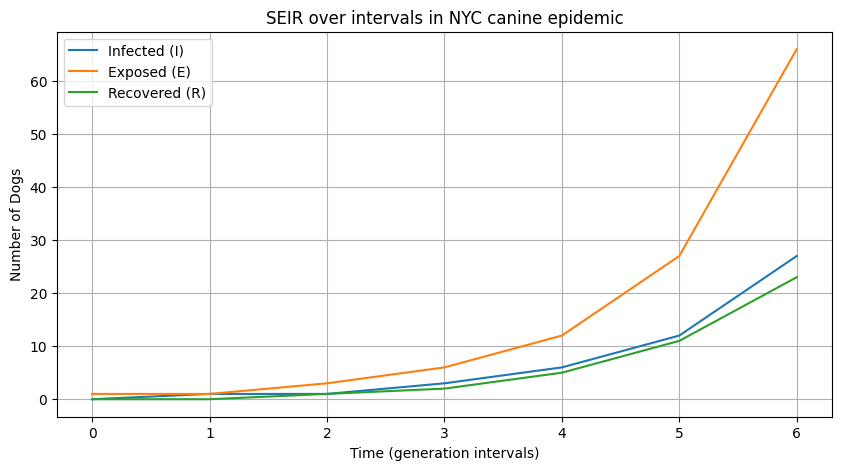

In [85]:

plt.subplots(figsize=(10, 5))
#plt.plot(range(n_generation_intervals + 1), SEIR_report['Susceptible'], label="Susceptible (S)")
plt.plot(range(n_generation_intervals + 1), SEIR_report['Infected'], label="Infected (I)")
plt.plot(range(n_generation_intervals + 1), SEIR_report['Exposed'], label="Exposed (E)")
plt.plot(range(n_generation_intervals + 1), SEIR_report['Recovered'], label="Recovered (R)")
plt.xlabel("Time (generation intervals)")
plt.ylabel("Number of Dogs")
plt.title("SEIR over intervals in NYC canine epidemic")
plt.legend()
plt.grid(True)
plt.show()
plt.close()

